# PPO algorithm Implementation from scratch to solve "Lunar Lander" problem (Continuous version)

In [ ]:
# Load packages

import numpy as np
import matplotlib.pyplot as plt

from collections import deque, namedtuple

import torch
import torch.nn as nn
import torch.optim as optim

import gymnasium as gym
from tqdm import trange

def running_average(x, N):
    ''' 
    Function used to compute the running average of the last N elements of a vector x
    '''
    if len(x) >= N:
        y = np.copy(x)
        y[N-1:] = np.convolve(x, np.ones((N, )) / N, mode='valid')
    else:
        y = np.zeros_like(x)
    return y

Here we define a pytorch-compatible density function for the 1-D distribution

In [ ]:
def normal_density(x, mu, sigma):
    """ 
    Compute the normal (Gaussian) density for a given tensor of x, mean (mu), and standard deviation (sigma)
    Inputs are tensors.
    """
    factor= 1.0/(torch.sqrt(2*np.pi*sigma))
    expo = torch.exp(-((x-mu)**2)/(2*sigma))
    return factor*expo

Here we define our main classes (Replay buffer, Networks, etc)

In [ ]:
Experience = namedtuple('Experience', ['state', 'action', 'reward', 'next_state', 'done'])

class Agent(object):
    ''' 
        Base agent class
        Args:
            n_actions (int): actions dimensionality

        Attributes:
            n_actions (int): where we store the dimensionality of an action
    '''
    def __init__(self, n_actions: int):
        self.n_actions = n_actions

    def forward(self, state: np.ndarray):
        ''' Performs a forward computation '''
        pass

    def backward(self):
        ''' Performs a backward pass on the network '''
        pass

class ExperienceReplayBuffer(object):
    """
    Class used to store a buffer containing experiences of the RL agent.
    """
    def __init__(self, maximum_length):
        self.buffer = deque(maxlen=maximum_length)

    def append(self, experience: Experience):
        self.buffer.append(experience)

    def __len__(self):
        return len(self.buffer)

    def sample_batch(self, n):
        """ 
        Function used to sample experiences from the buffer.
        Returns 5 lists, each of size n: state, actions, rewards, next states, and done flags.
        """

        if n > len(self.buffer):
            raise IndexError('Tried to sample too many elements from the buffer!')

        # Sample without replacement the indices of the experiences
        # np.random.choice takes 3 parameters: number of elements of the buffer,
        # number of elements to sample and replacement.
        indices = np.random.choice(len(self.buffer), size=n, replace=False)
        batch = [self.buffer[i] for i in indices]
        return zip(*batch)

### Neural Networks ###

class actor_net(nn.Module):
    """ Create a feedforward neural network """
    def __init__(self, input_size: int, output_size: int):
        super(actor_net, self).__init__()

        # Create input layer with ReLU activation
        self.input_layer = nn.Linear(input_size, 400) #Shared Input Layer
        self.input_layer_activation = nn.ReLU()
        
        self.input_mean = nn.Linear(400, 200)
        self.output_mean= nn.Linear(200, output_size)
        self.input_sigma= nn.Linear(400,200)
        self.output_sigma= nn.Linear(200, output_size)
        
    def forward(self, x: torch.Tensor):
        x = torch.relu(self.input_layer(x))
    
        # Mean head
        mean = torch.relu(self.input_mean(x))
        mean = torch.tanh(self.output_mean(mean))
        
        # Sigma head
        sigma = torch.relu(self.input_sigma(x))
        sigma = torch.sigmoid(self.output_sigma(sigma))
        
        return mean, sigma
    
class critic_net(nn.Module):
    """ 
    Create a feedforward neural network 
    """
    def __init__(self, input_size : int, output_size : int):
        super(critic_net, self).__init__()

        self.input_layer = nn.Linear(input_size, 400)
        self.input_layer1 = nn.Linear(400, 200)
        self.output_layer = nn.Linear(200, output_size)
        
    def forward(self, x):
        x = torch.relu(self.input_layer(x))
        x = torch.relu(self.input_layer1(x))
        return self.output_layer(x)    
    
class RandomAgent(Agent):
    ''' Agent taking actions uniformly at random, child of the class Agent'''
    def __init__(self, n_actions: int):
        super(RandomAgent, self).__init__(n_actions)

    def forward(self, state: np.ndarray) -> np.ndarray:
        ''' Compute a random action in [-1, 1] '''
        return np.clip(-1 + 2 * np.random.rand(self.n_actions), -1, 1)

Below we fix our parameters and we launch the training

In [ ]:
# Import and initialize Lunar Lander Continuous Environment
env = gym.make('LunarLanderContinuous-v3')

env.reset()

# Parameters
N_episodes = 1600              # Number of episodes to run for training
discount_factor = 0.99        # Value of gamma
n_ep_running_average = 50      # Running average of 50 episodes
n_actions = len(env.action_space.high)               # Number of available actions

dim_state = len(env.observation_space.high)  # State dimensionality
epsilon = 0.2
M = 10
lr_critic = 1e-3
lr_actor = 1e-5
L = 10000

# Reward
episode_reward_list = []  # Used to save episodes reward
episode_number_of_steps = []

### Filling up Buffer with Random experiences
agent = RandomAgent(n_actions)

### Create network ###
actor = actor_net(input_size=dim_state, output_size=n_actions)
critic = critic_net(input_size=dim_state, output_size=1)

### Create optimizer ###
optimizer_actor = optim.Adam(actor.parameters(), lr=lr_actor)
optimizer_critic = optim.Adam(critic.parameters(), lr=lr_critic)

# Training process
EPISODES = trange(N_episodes, desc='Episode: ', leave=True)

for episode in EPISODES:
    
    buffer = ExperienceReplayBuffer(maximum_length=L)

    total_episode_reward=0
    state, _ = env.reset()
    done = False 
    t=0 
    
    G=[]
    states=[]
    actions=[]
    
    while not done:
        # env.render() # Render the environment
        with torch.no_grad():
            
            states.append(state)
            mu, var = actor(torch.tensor(np.array([state]), dtype=torch.float32))
            mu = mu.detach().numpy()
            std = torch.sqrt(var).detach().numpy()

            action = np.clip(np.random.normal(mu, std), -1, 1).flatten()            
            actions.append(action)

        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        
        # COMPUTE Relevant measures
        G.append(reward)
        if len(G)>1:
            for i in range(len(G)-1):
                G[i] += (discount_factor**(t-i))*reward

        # Update episode reward
        total_episode_reward += reward

        # Append experience to the buffer
        exp = Experience(state, action, reward, next_state, done)
        buffer.append(exp)
    
        # Update state for next iteration
        state = next_state
        t += 1
    
    #Compute advantage and old_pi and Psi as targets in order to perform training
    G = torch.tensor(G, requires_grad=False, dtype=torch.float32)
    states = torch.tensor(np.array(states), requires_grad=True, dtype=torch.float32)
    actions = torch.tensor(np.array(actions), requires_grad=False, dtype=torch.float32)
    V = critic(states)
    V = torch.reshape(V, G.shape)
    Psi = G - V.detach()
    means, sigmas = actor(states)
    val1, val2 = normal_density(actions[:,0], means[:,0], sigmas[:,0]), normal_density(actions[:,1], means[:,1], sigmas[:,1])
    pi = val1*val2
    old_pi = pi.detach()
    
    for n in range(1, M+1):
        # Optimize Critic
        critic.train()
        
        # Compute Targets
        V = critic(states)
        V = torch.reshape(V, G.shape)
        
        means, sigmas = actor(states)
        val1, val2 = normal_density(actions[:,0], means[:,0], sigmas[:,0]), normal_density(actions[:,1], means[:,1], sigmas[:,1])
        pi= val1 * val2
        loss_critic = nn.functional.mse_loss(V, G.detach())
        
        optimizer_critic.zero_grad()
            
        # Compute gradient
        loss_critic.backward()
        
        nn.utils.clip_grad_norm_(critic.parameters(), max_norm=1.)

        # Perform backward pass (backpropagation)
        optimizer_critic.step()
        
        # Optimize Actor
        r = torch.div(pi, old_pi)
        
        c_eps= torch.max(
            torch.min(
                r, 
                torch.tensor(1+epsilon, requires_grad=False, dtype=torch.float32)), 
            torch.tensor(1-epsilon, requires_grad=False, dtype=torch.float32)
            )
        
        Psi=Psi.detach()
        actor.train()
        
        loss_actor= -torch.mean(torch.min(r*Psi, c_eps*Psi))
        
        optimizer_actor.zero_grad()
            
        # Compute gradient
        loss_actor.backward()
        
        nn.utils.clip_grad_norm_(actor.parameters(), max_norm=1.)
        optimizer_actor.step()
    
    # Add rewards and number of steps
    episode_reward_list.append(total_episode_reward)
    episode_number_of_steps.append(t)
    EPISODES.set_description("Episode {} - Reward/Steps: {:.1f}/{} - Avg. Reward/Steps: {:.1f}/{}".format(
        episode, 
        total_episode_reward, 
        t, 
        running_average(episode_reward_list, n_ep_running_average)[-1],
        running_average(episode_number_of_steps, n_ep_running_average)[-1]
        )
    )
  
env.close()

Episode 1599 - Reward/Steps: 39.6/141 - Avg. Reward/Steps: 124.1/788: 100%|██████████| 1600/1600 [32:35<00:00,  1.22s/it]  


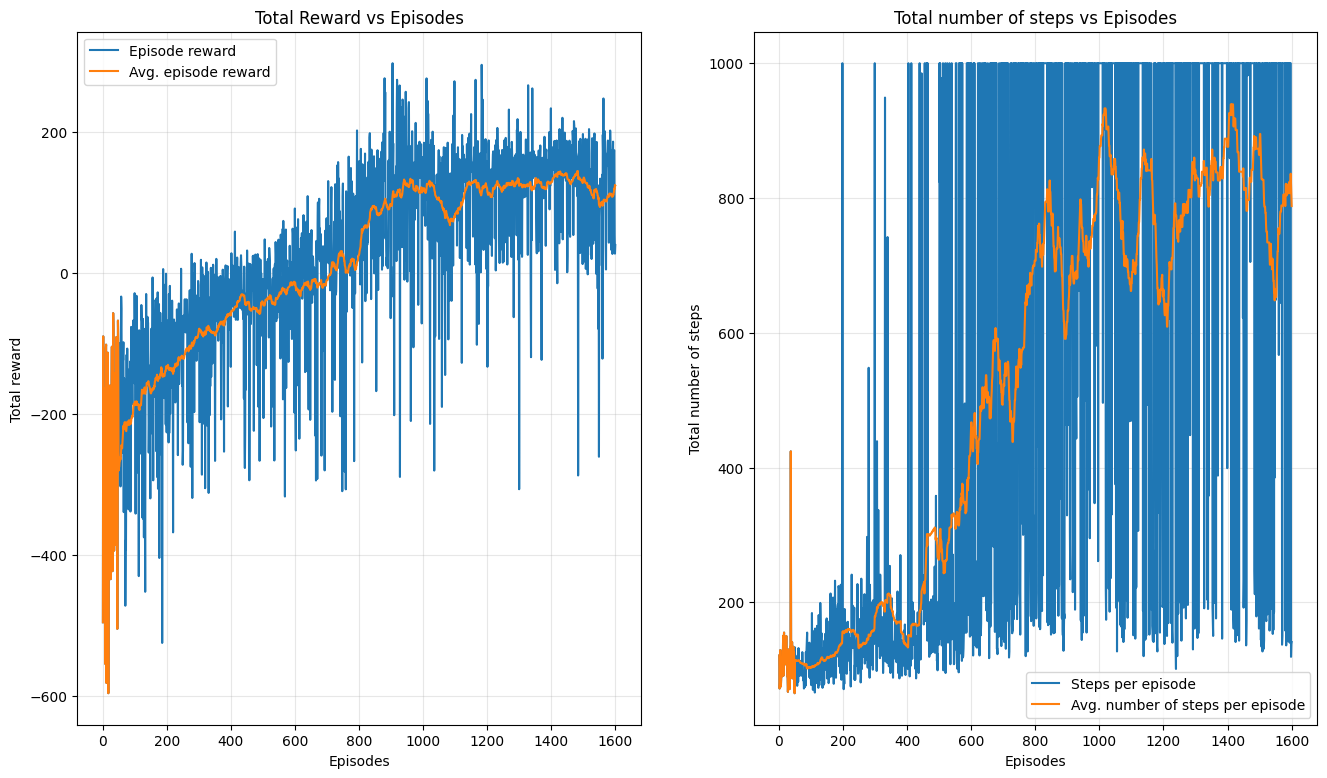

In [8]:
# Plot Rewards and steps

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 9))

ax[0].plot([i for i in range(1, N_episodes + 1)], episode_reward_list, label='Episode reward')
ax[0].plot([i for i in range(1, N_episodes + 1)], running_average(
    episode_reward_list, n_ep_running_average), label='Avg. episode reward')
ax[0].set_xlabel('Episodes')
ax[0].set_ylabel('Total reward')
ax[0].set_title('Total Reward vs Episodes')
ax[0].legend()
ax[0].grid(alpha=0.3)

ax[1].plot([i for i in range(1, N_episodes + 1)], episode_number_of_steps, label='Steps per episode')
ax[1].plot([i for i in range(1, N_episodes + 1)], running_average(
    episode_number_of_steps, n_ep_running_average), label='Avg. number of steps per episode')
ax[1].set_xlabel('Episodes')
ax[1].set_ylabel('Total number of steps')
ax[1].set_title('Total number of steps vs Episodes')
ax[1].legend()
ax[1].grid(alpha=0.3)

plt.show()

# Check Solution

Here we check the validity of our model. We achieve high performances with the above parameters (200+ average reward over 50 episodes)

In [31]:
# Load model
model = actor
print('Network model: {}'.format(model))

env = gym.make('LunarLanderContinuous-v3')
env.reset()

# Parameters
N_EPISODES = 50
CONFIDENCE_PASS = 125

# Reward
episode_reward_list = []  # Used to store episodes reward

# Simulate episodes
print('Checking solution...')
EPISODES = trange(N_EPISODES, desc='Episode: ', leave=True)
for i in EPISODES:
    EPISODES.set_description("Episode {}".format(i))
    # Reset enviroment data
    done = False
    state, _ = env.reset()
    total_episode_reward = 0.
    
    while not done:
        mu, var = actor(torch.tensor(np.array([state]), dtype=torch.float32))
        mu = mu.detach().numpy()
        std = torch.sqrt(var).detach().numpy()
        action = np.clip(np.random.normal(mu, std), -1, 1).flatten()  

        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated

        total_episode_reward += reward
        state = next_state

    # Append episode reward
    episode_reward_list.append(total_episode_reward)

    env.close()

avg_reward = np.mean(episode_reward_list)
confidence = np.std(episode_reward_list) * 1.96 / np.sqrt(N_EPISODES)

print('Policy achieves an average total reward of {:.1f} +/- {:.1f} with confidence 95%.'.format(avg_reward, confidence))

if avg_reward - confidence > CONFIDENCE_PASS or avg_reward + confidence > CONFIDENCE_PASS:
    print('Your policy passed the test!')
else:
    print("Your policy did not pass the test! The average reward of your policy needs to be greater than {} with 95% confidence".format(CONFIDENCE_PASS))

Network model: actor_net(
  (input_layer): Linear(in_features=8, out_features=400, bias=True)
  (input_layer_activation): ReLU()
  (input_mean): Linear(in_features=400, out_features=200, bias=True)
  (output_mean): Linear(in_features=200, out_features=2, bias=True)
  (act_mean): Tanh()
  (input_sigma): Linear(in_features=400, out_features=200, bias=True)
  (output_sigma): Linear(in_features=200, out_features=2, bias=True)
  (act_sigma): Sigmoid()
)
Checking solution...


Episode 49: 100%|██████████| 50/50 [00:28<00:00,  1.73it/s]

Policy achieves an average total reward of 112.0 +/- 18.6 with confidence 95%.
Your policy passed the test!
